# Import Libraries
---

This is second code for House price prediction EDA Please see before [LINK](https://www.kaggle.com/code/ignorelee/gpu-based-house-price-eda-with-rapids).<br/>
Now, we are porting that GPU-based code to [RAPIDS](https://rapids.ai/) on [Dask](https://docs.dask.org/en/stable/).<br/>
Our system environments include two NVIDIA GTX 2080 Supers, and the OS is Ubuntu 20.04 LTS.<br/>
I hope you feel the speed increase achieved by just using RAPDIS <br/>
If you see more RAPIDS code, See my github.

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/github-181717?style=flat-square&logo=github&logoColor=FFFFFF" />
</a>

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/DASK-FC6E6B?style=flat-square&logo=dask&logoColor=FFFFFF"/>
</a>

In [1]:
import time

import cupy as cp

import cudf
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
cp.cuda.Device(0).use()

<CUDA Device 0>

# Make Timer
---

Check for CPU-based libraries versus GPU-based libraries.

In [3]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

# Data Load
---

I run this code on my local system. <br/>
If you want to run it, change the path below.

In [4]:
data_path = "./data/uk_housing.parquet"

# Load Data
---

Dask can be used similarly to cuDF or pandas,<br/>
but it operates a bit differently, primarily running on lazy execution.<br/>
If you want to see the results of your work, you need to run it with .compute().<br/>

In [5]:
with Timer("DASK"):
    gdf = dd.read_parquet(data_path, npartitions=40)
    

DASK execute time : 0.0303 seconds


## Visualize my workflow with DAG
---

Dask does not execute tasks immediately. <br/>
You can visualize your Dask workflow with the ".visualize()" method. <br/>
The ".visualize()" method displays a Directed Acyclic Graph (DAG), which clearly represents your workflow.<br/>
If you run ".compute()", you can see your dataframe.<br/>


In [6]:
gdf.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

# Persist() your Workflow
---

The ".compute()" method has some limitations.<br/> 
Firstly, it always begins by reading from a Parquet file. <br/>
Although this is a simple structure, it can be both time-consuming and memory-intensive. <br/>
However, there's no need to worry; there is an alternative that can help save both time and memory.<br/>
The ".persist()" method allows you to move your workflow into memory, helping to optimize resource usage. <br/>
Below, you can see how to modify your workflow to incorporate this method.

In [7]:
gdf = gdf.persist()

In [8]:
gdf.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [9]:
with Timer("DASK"):
    print(gdf.describe())

<dask_cudf.DataFrame | 62 tasks | 1 npartitions>
DASK execute time : 0.1677 seconds


/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cudf/core/dataframe.py:5059: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cudf/core/series.py:3334: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


In [10]:
with Timer("DASK"):
    gdf = gdf.dropna()

DASK execute time : 0.0046 seconds


/tmp/ipykernel_2898583/927096520.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)
/tmp/ipykernel_2898583/927096520.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)
/tmp/ipykernel_2898583/927096520.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(count_gdf.index, rotation=90)


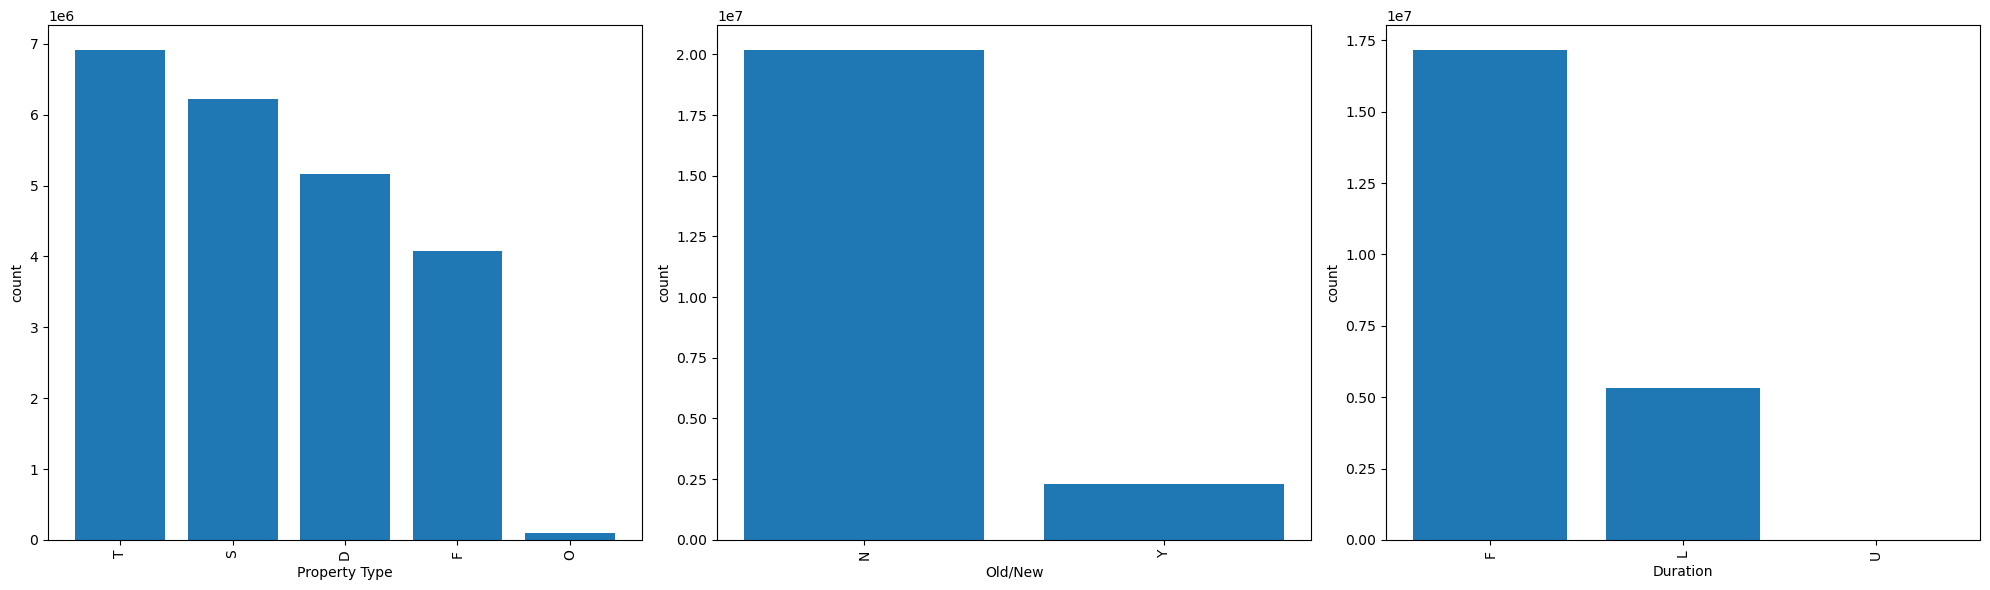

DASK execute time : 0.5110 seconds


In [11]:
cat_cols = ['Property Type','Old/New','Duration']

with Timer("DASK"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    values = gdf[cat_cols].persist()
    
    for i, var in enumerate(cat_cols):

        count_gdf = values[var].compute().value_counts().to_pandas()
        axs[i].bar(count_gdf.index, count_gdf)
        axs[i].set_ylabel("count")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(count_gdf.index, rotation=90)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

del values

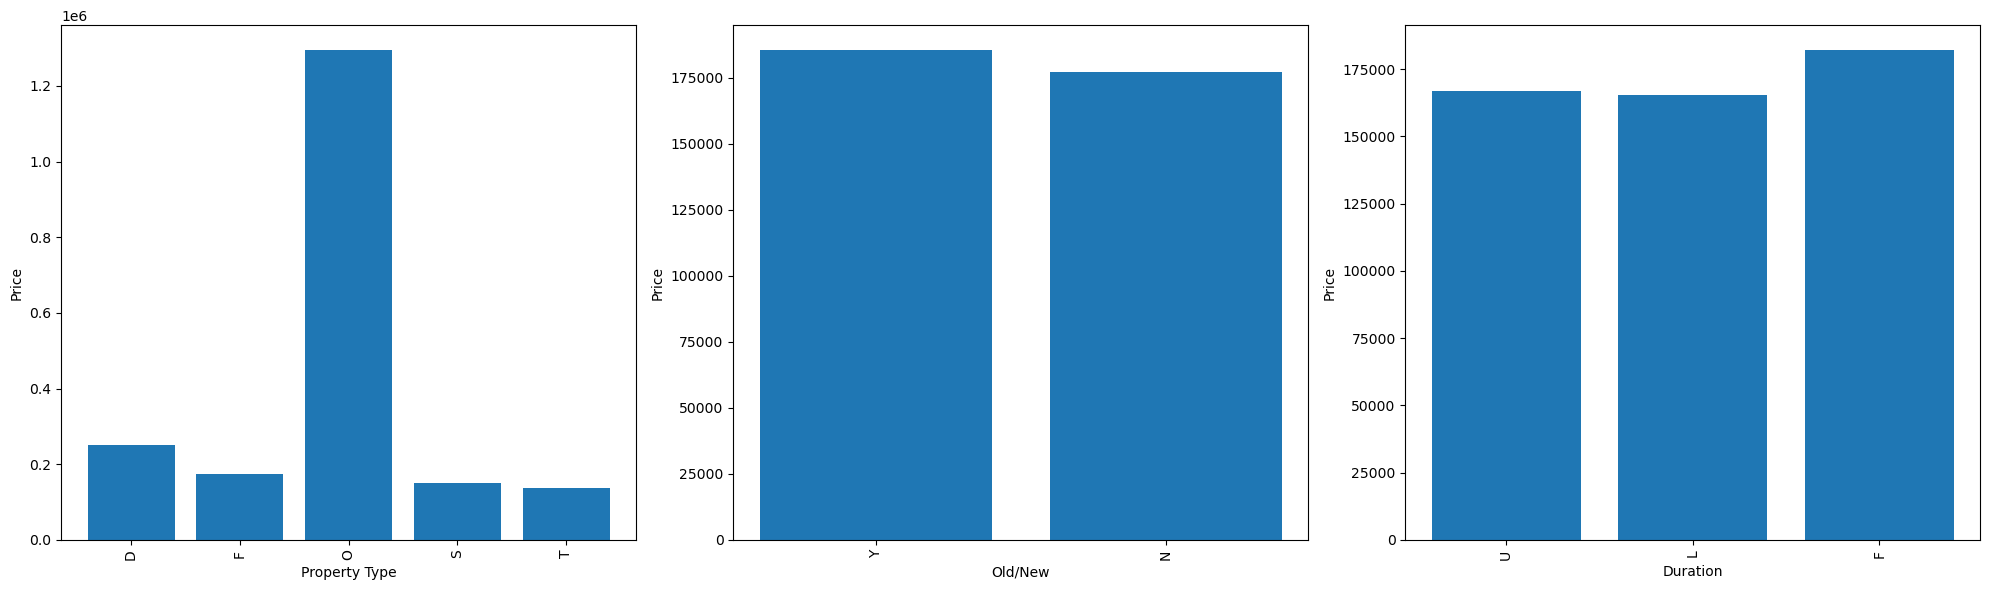

DASK execute time : 0.5102 seconds


In [12]:
cat_cols = ['Property Type','Old/New','Duration', "Price"]

with Timer("DASK"):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    axs = axs.flatten()
    values = gdf[cat_cols].persist()
    
    for i, var in enumerate(cat_cols[:3]):
        prices = values.groupby(var)["Price"].mean().compute().to_pandas()
        axs[i].bar(prices.index, prices)
        axs[i].set_ylabel("Price")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(prices.index, rotation=90)
        
    
    fig.tight_layout()
    
    plt.show()
    plt.close()
del values

## Conclusion
---

- DASK-base looks faster!
- However, it is not always faster, and the coding can be quite challenging.

## Using Date Time Index
---

Use a DateTimeIndex to visualize house prices by date.

In [13]:
with Timer("DASK"):
    date_gpu = dd.to_datetime(gdf['Date of Transfer'])
    gdf['year']  = date_gpu.dt.year
    gdf['month'] = date_gpu.dt.month
    gdf['date']  = date_gpu.dt.day

DASK execute time : 0.0234 seconds


In [14]:
gdf.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Property Type', 'Old/New', 'Duration', 'Town/City', 'District',
       'County', 'PPDCategory Type', 'Record Status - monthly file only',
       'year', 'month', 'date'],
      dtype='object')

In [15]:
with Timer("DASK"):
    gdf = gdf.drop(columns=['Transaction unique identifier','Date of Transfer','Record Status - monthly file only'])


DASK execute time : 0.0056 seconds


In [16]:
gdf.columns

Index(['Price', 'Property Type', 'Old/New', 'Duration', 'Town/City',
       'District', 'County', 'PPDCategory Type', 'year', 'month', 'date'],
      dtype='object')

# Visualize price of UK house by date
---

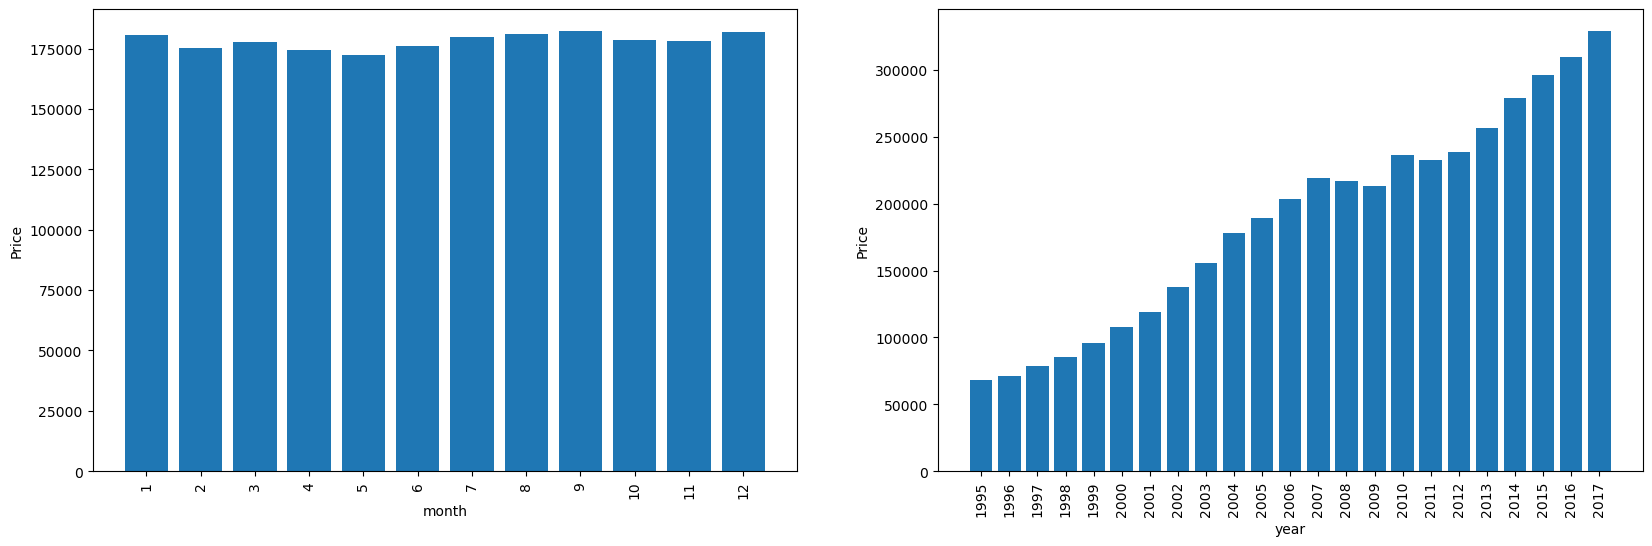

DASK execute time : 0.6131 seconds


In [17]:
date_cols = ['month','year']

with Timer("DASK"):
    fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(20,6))
    axs = axs.flatten()
    values = gdf[date_cols + ["Price"]].persist()
    for i , var in enumerate(date_cols):
        prices = values.groupby(var)["Price"].mean().compute().sort_values().to_pandas()
        axs[i].bar(prices.index, prices)
        axs[i].set_xticks(prices.index)
        axs[i].set_ylabel("Price")
        axs[i].set_xlabel(var)
        
        axs[i].set_xticklabels(prices.index, rotation=90)
        
    fig.get_tight_layout()
    
    plt.show()
    plt.close()
    
del values

# Count Plot Property Type and Old/New

<Figure size 640x480 with 0 Axes>

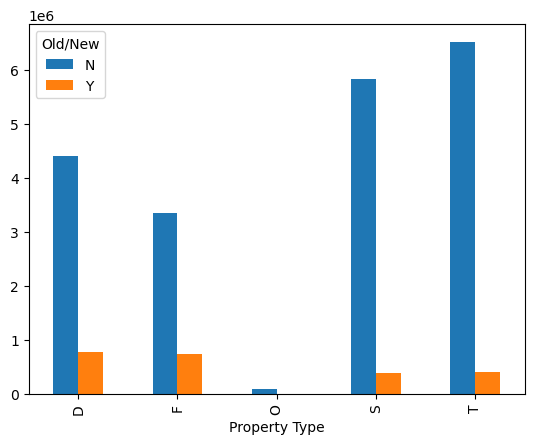

DASK execute time : 0.3791 seconds


In [18]:
with Timer("DASK"):
    fig = plt.figure()
    
    values = gdf[["Property Type","Old/New"]].compute().groupby("Property Type").value_counts().sort_values().to_pandas()
    values.unstack().plot(kind="bar")
    fig.tight_layout()
    
    plt.show()
    plt.close()
del values

# EDA Town/City

DASK execute time : 0.2632 seconds


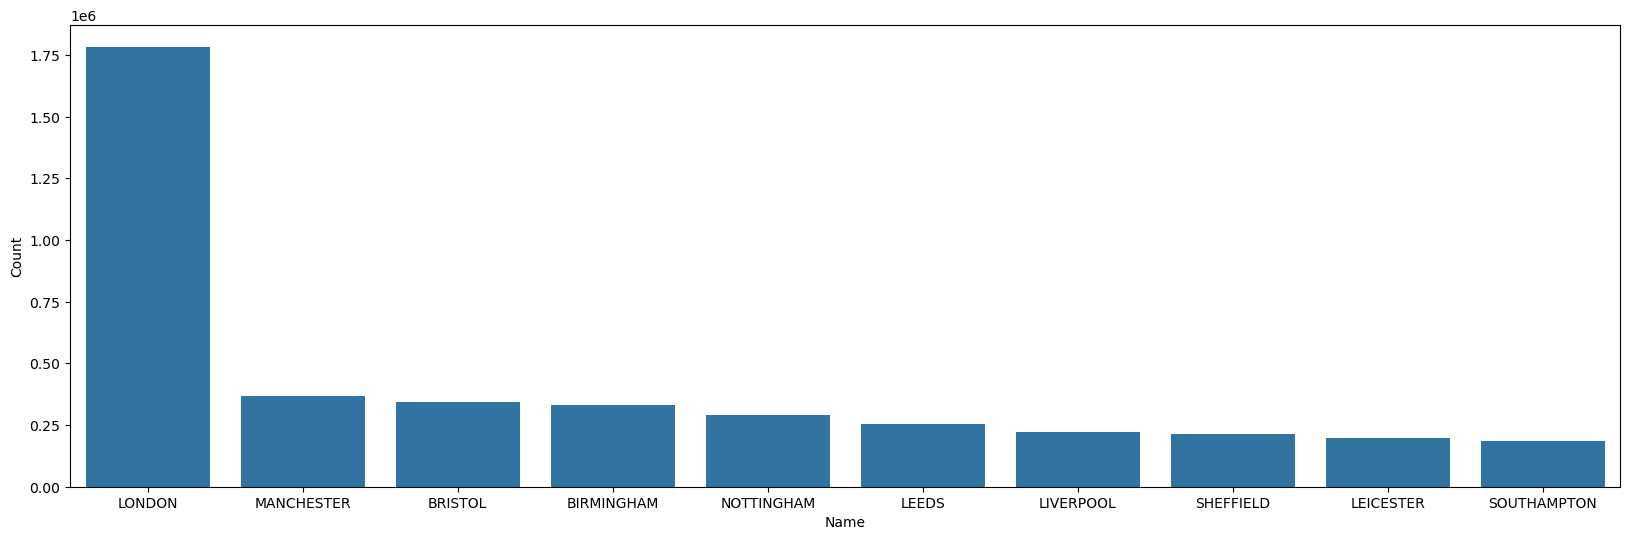

In [19]:
with Timer("DASK"):
    gcount_cities = gdf['Town/City'].compute().value_counts()
    gtop_cities = gcount_cities.head(10).reset_index()
    # gdf_city = cudf.DataFrame(gtop_cities)
    gtop_cities.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gtop_cities.to_pandas(),x='Name',y='Count')

del gcount_cities

# EDA District

DASK execute time : 0.2763 seconds


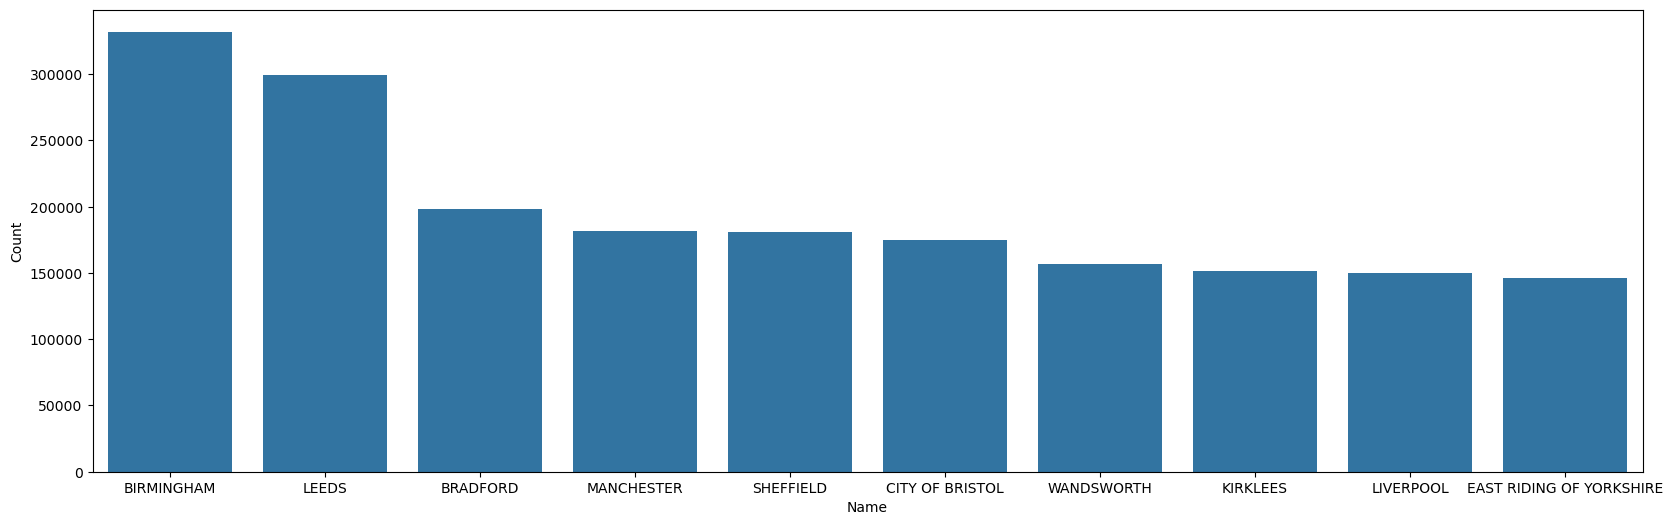

In [20]:
with Timer("DASK"):
    gcount_district =  gdf['District'].compute().value_counts()
    gtop_district = gcount_district.head(10)
    gdf_district = cudf.DataFrame(gtop_district).reset_index()
    gdf_district.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gdf_district.to_pandas(),x='Name',y='Count')

del gcount_district
del gtop_district

gpu execute time : 0.2710 seconds


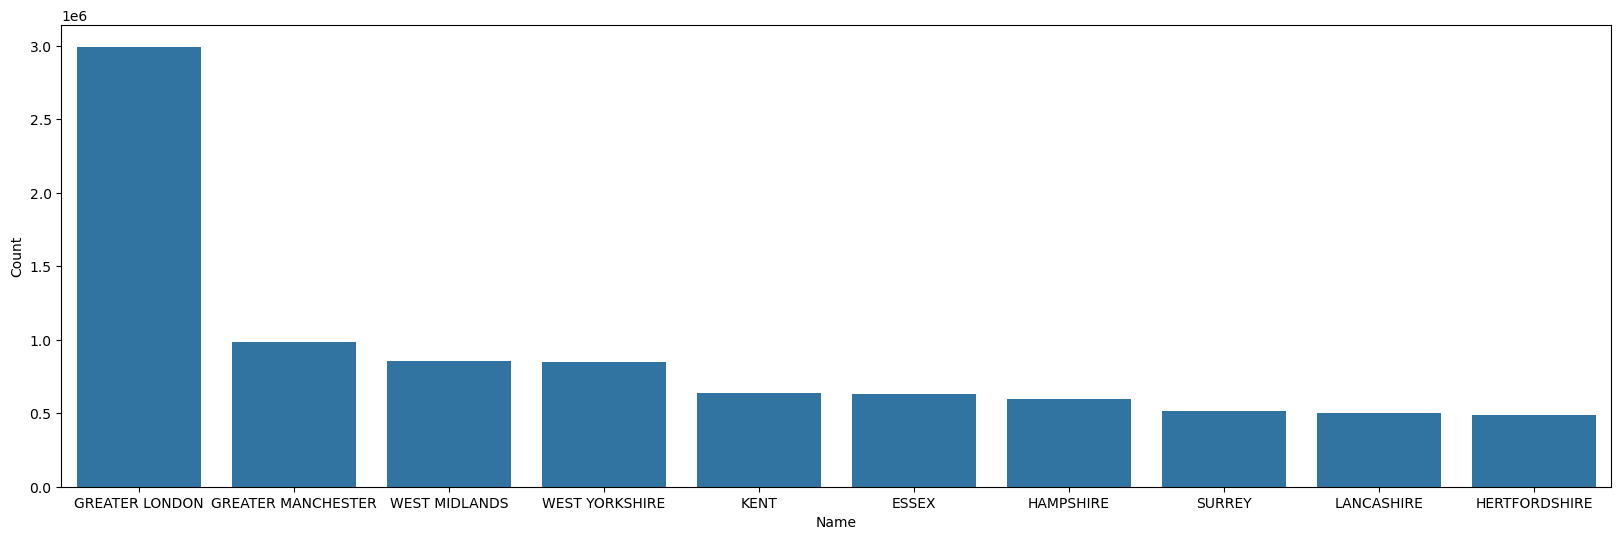

In [21]:
with Timer("gpu"):
    gcount_county = gdf['County'].compute().value_counts()
    gtop_county = gcount_county.head(10)
    gdf_county = cudf.DataFrame(gtop_county).reset_index()
    gdf_county.columns = ['Name','Count']
    plt.figure(figsize=(20,6))
    sns.barplot(data=gdf_county.to_pandas(),x='Name',y='Count')
    
del gcount_county
del gtop_county

# EDA Price by Town/City

DASK execute time : 0.3113 seconds


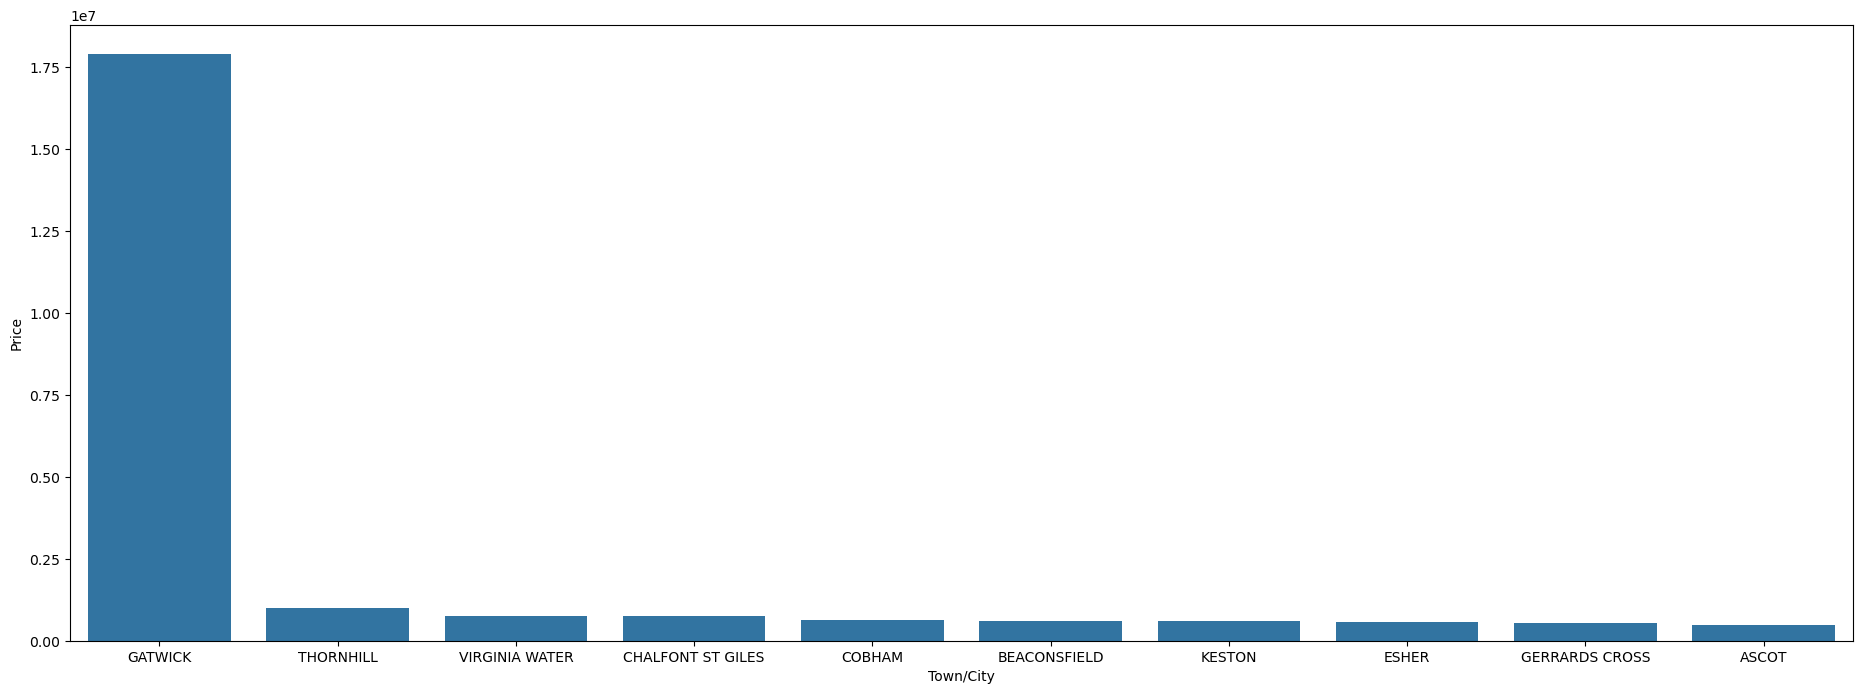

In [22]:
with Timer("DASK"):
    gprice = gdf[["Town/City", 'Price']].groupby("Town/City")['Price'].mean().compute()
    gprice = gprice.sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(23,8))
    ax = sns.barplot(data = gprice.to_pandas(), x = "Town/City", y = "Price")


# EDA Price by District

DASK execute time : 0.4096 seconds


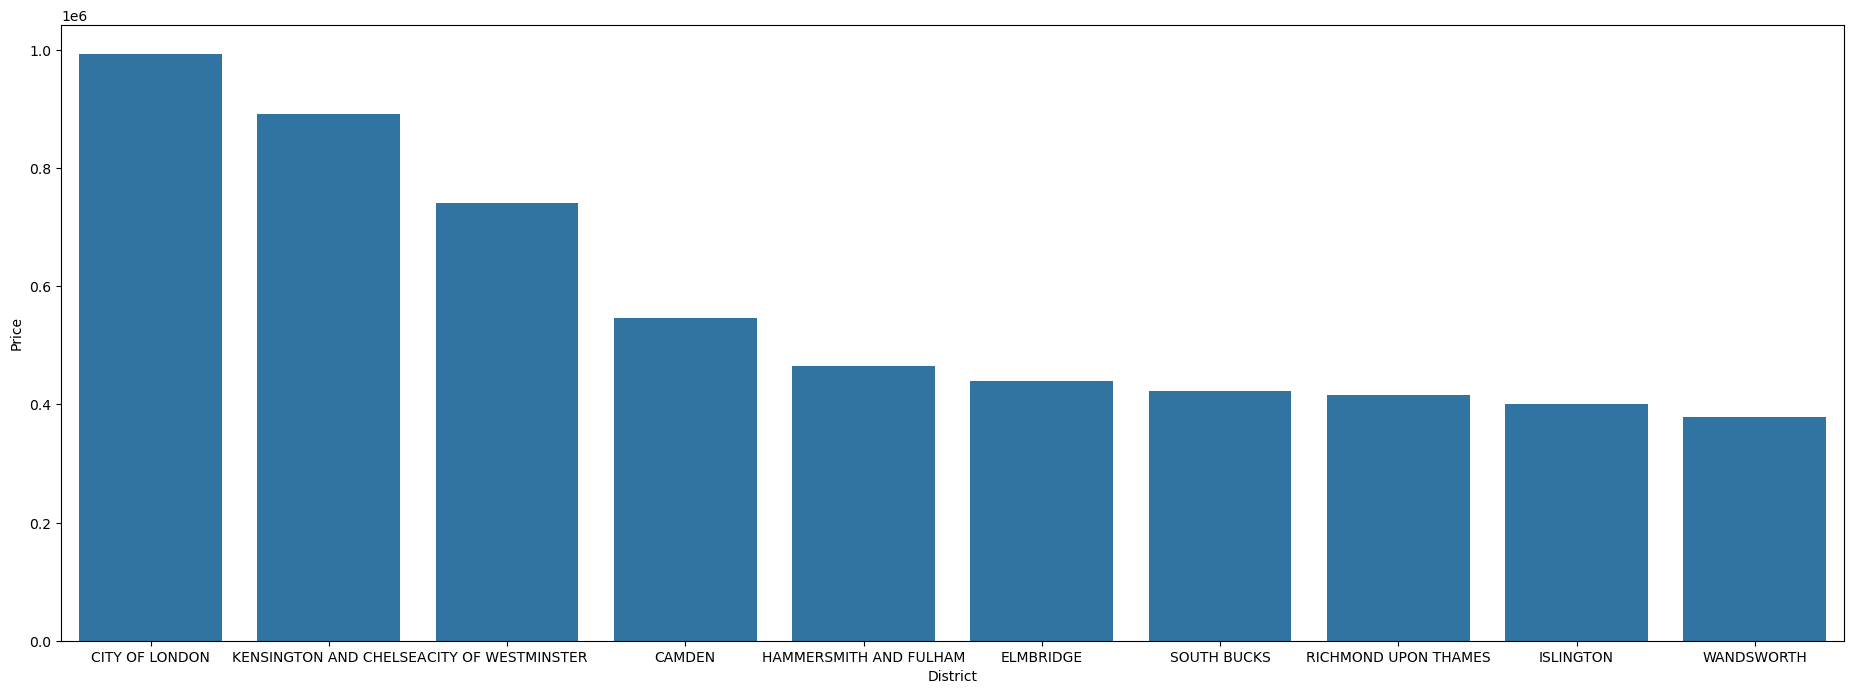

In [23]:
with Timer("DASK"):
    gprice = gdf[['District', 'Price']].groupby("District")['Price'].mean().compute()
    gprice = gprice.sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(23,8))
    ax = sns.barplot(data = gprice.to_pandas(), x = "District", y = "Price")


## Acknowledgements
---

This work procced by modulabs's NVIDIA - Data Engineering with RAPIDS in Korea <br/>
Learn more : <br/>

<a href="https://modulabs.notion.site/NVIDIA-Data-Engineering-with-RAPIDS-LAB-136c69bcb0f34c458e7553b945dacad7?pvs=4">
<img  src="https://img.shields.io/badge/notion-000000?style=flat-square&logo=notion&logoColor=FFFFFF" />
</a>
<a href="https://modulabs.co.kr/">
<img  src="https://img.shields.io/badge/모두의-연구소-FE5196?style=flat-square" />
</a>
<a href="https://www.youtube.com/watch?v=1c3Zw31JhgQ">
<img  src="https://img.shields.io/badge/Youtube-FF0000?style=flat-square&logo=youtube&logoColor=FFFFFF" />
</a>